In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import tree
from mpl_toolkits import mplot3d
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV

%matplotlib inline

In [2]:
from google.colab import files
uploaded = files.upload()

ModuleNotFoundError: No module named 'google'

In [32]:
# Loading the data
pathrise=pd.read_excel('Data_Pathrise.xlsx')

# Exploratory Data Analysis

What are the variables (features) in our dataset? Which are the Predictor Variables and which is the Target Variables?

TV: 'placed'

PV: All others

Categorical variables such as 'program_duration_days', 'professional_experience', 'length_of_job_search' are ordinal attributes. All the rest of the categorical features are nominal attributes. One-hot-encoding is to be carried out for all the nominal attributes.

The testing set is selected by using the 'pathrise status' which are either 'Active' or 'Break'. The training set will be the Pathrise data without the testing set. A validation set should be made by doing a split of the training dataset.

Analysis should be two steps:

1) Determine what are the characteristics of fellows being placed. For that eliminate the 'program_duration_days' columns. Then see which columns contributes to it.

2) After determining the fellows, who get placed, maybe use regression to see how long do they take to get placed.

# Other considerations

A) Balance the training data set.

B) Drop columns that seemingly have no effect such as 'id' and 'cohort_tag'. 'Race' and 'gender' might be affecting the prediction, but they are understandably complicated, so dropping them for training seems reasonable. 'placed' column should be removed in training as it's the target variable.

C) Limit the 'number of applications' to less than 150.

D) Do the encoders for ordinal and nominal categories in first pathrise data. Then add missing values with mean.




In [33]:
pathrise.head()

,id,pathrise_status,primary_track,cohort_tag,program_duration_days,placed,employment_status,highest_level_of_education,length_of_job_search,biggest_challenge_in_search,professional_experience,work_authorization_status,number_of_interviews,number_of_applications,gender,race
0,1,Active,SWE,OCT19A,NaN,0,Unemployed,Bachelor's Degree,3-5 months,Hearing back on my applications,3-4 years,Canada Citizen,2.0,900,Male,Non-Hispanic White or Euro-American
1,2,Active,PSO,JAN20A,NaN,0,Unemployed,"Some College, No Degree",3-5 months,Getting past final round interviews,1-2 years,Citizen,6.0,0,Male,Non-Hispanic White or Euro-American
2,3,Closed Lost,Design,AUG19B,0.0,0,Employed Part-Time,Master's Degree,Less than one month,Figuring out which jobs to apply for,Less than one year,Citizen,0.0,0,Male,East Asian or Asian American
3,4,Closed Lost,PSO,AUG19B,0.0,0,Contractor,Bachelor's Degree,Less than one month,Getting past final round interviews,Less than one year,Citizen,5.0,25,Male,Decline to Self Identify
4,5,Placed,SWE,AUG19A,89.0,1,Unemployed,Bachelor's Degree,1-2 months,Hearing back on my applications,1-2 years,F1 Visa/OPT,10.0,100,Male,East Asian or Asian American


In [34]:
# Columns/feature names

pathrise.columns

Index(['id', 'pathrise_status', 'primary_track', 'cohort_tag',
       'program_duration_days', 'placed', 'employment_status ',
       'highest_level_of_education', 'length_of_job_search',
       'biggest_challenge_in_search', 'professional_experience',
       'work_authorization_status', 'number_of_interviews',
       'number_of_applications', 'gender', 'race'],
      dtype='object')

In [31]:
pathrise['professional_experience'].value_counts()

1-2 years             882
Less than one year    618
3-4 years             558
5+ years              264
Name: professional_experience, dtype: int64

In [35]:
pathrise=pathrise.rename(columns={'employment_status ': 'employment_status'});
# Missing value counts per columns

for i in pathrise.columns:
    print(i, ':', (pathrise[i].isnull()).sum(), 'missing values')

id : 0 missing values
pathrise_status : 0 missing values
primary_track : 0 missing values
cohort_tag : 8 missing values
program_duration_days : 616 missing values
placed : 0 missing values
employment_status : 229 missing values
highest_level_of_education : 58 missing values
length_of_job_search : 74 missing values
biggest_challenge_in_search : 24 missing values
professional_experience : 222 missing values
work_authorization_status : 284 missing values
number_of_interviews : 218 missing values
number_of_applications : 0 missing values
gender : 492 missing values
race : 18 missing values


Ordinal encoding for columns such as 'length_of_job_search', 'professional_experience'. Then, instead of dropping the missing values for these columns, put the median values (because of the skewness) for the encoded columns.

In [885]:
## Did ordinal categorical to numerical categorical by 'find and replace'.
#
#cleanup_cols = {'professional_experience_ord':{'Less than one year': 1, '1-2 years': 2, '3-4 years': 3, '5+ years': 5},
#                'length_of_job_search_ord':{'Less than one month': 1, '1-2 months': 2, '3-5 months': 3, '6 months to a year': 4, 'Over a year': 5}}      
#pathrise['professional_experience_ord']=pathrise['professional_experience']
#pathrise['length_of_job_search_ord']=pathrise['length_of_job_search']
#pathrise = pathrise.replace(cleanup_cols)
#
## Used the median to fill the missing values for those two columns.
#
#pathrise['professional_experience_ord']=pathrise['professional_experience_ord'].fillna(pathrise['professional_experience_ord'].median())
#pathrise['length_of_job_search_ord']=pathrise['length_of_job_search_ord'].fillna(pathrise['length_of_job_search_ord'].median())
#pathrise.head()

,id,pathrise_status,primary_track,cohort_tag,program_duration_days,placed,employment_status,highest_level_of_education,length_of_job_search,biggest_challenge_in_search,professional_experience,work_authorization_status,number_of_interviews,number_of_applications,gender,race,professional_experience_ord,length_of_job_search_ord
0,1,Active,SWE,OCT19A,NaN,0,Unemployed,Bachelor's Degree,3-5 months,Hearing back on my applications,3-4 years,Canada Citizen,2.0,900,Male,Non-Hispanic White or Euro-American,3.0,3.0
1,2,Active,PSO,JAN20A,NaN,0,Unemployed,"Some College, No Degree",3-5 months,Getting past final round interviews,1-2 years,Citizen,6.0,0,Male,Non-Hispanic White or Euro-American,2.0,3.0
2,3,Closed Lost,Design,AUG19B,0.0,0,Employed Part-Time,Master's Degree,Less than one month,Figuring out which jobs to apply for,Less than one year,Citizen,0.0,0,Male,East Asian or Asian American,1.0,1.0
3,4,Closed Lost,PSO,AUG19B,0.0,0,Contractor,Bachelor's Degree,Less than one month,Getting past final round interviews,Less than one year,Citizen,5.0,25,Male,Decline to Self Identify,1.0,1.0
4,5,Placed,SWE,AUG19A,89.0,1,Unemployed,Bachelor's Degree,1-2 months,Hearing back on my applications,1-2 years,F1 Visa/OPT,10.0,100,Male,East Asian or Asian American,2.0,2.0


In [36]:
pathrise.describe(percentiles=[.25, .5, .75, .95])

,id,program_duration_days,placed,number_of_interviews,number_of_applications
count,2544.000000,1928.000000,2544.000000,2326.000000,2544.000000
mean,1272.500000,136.098548,0.375786,2.182287,36.500786
std,734.533866,125.860248,0.484420,2.959273,53.654896
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,636.750000,14.000000,0.000000,0.000000,9.000000
50%,1272.500000,112.000000,0.000000,1.000000,20.000000
75%,1908.250000,224.000000,1.000000,3.000000,45.000000
95%,2416.850000,348.950000,1.000000,7.000000,130.000000
max,2544.000000,548.000000,1.000000,20.000000,1000.000000


In [887]:
# Removing the outliers in 'number_of_applications': 400 and 1000 applications are way above 95%.

pathrise=pathrise[pathrise['number_of_applications']<150] 

pathrise_first=pathrise.drop(columns=['id', 'program_duration_days', 'cohort_tag', 'professional_experience', 'length_of_job_search']) # race and gender are dropped later before training
print('Before removing missing values, shape:', pathrise_first.shape)

pathrise_first.dropna(inplace=True)
print('After removing missing values, shape:', pathrise_first.shape)

Before removing missing values, shape: (2438, 13)
After removing missing values, shape: (1418, 13)


In [888]:
# Missing value counts per columns

for i in pathrise_first.columns:
    print(i, ':', (pathrise_first[i].isnull()).sum(), 'missing values')

pathrise_status : 0 missing values
primary_track : 0 missing values
placed : 0 missing values
employment_status : 0 missing values
highest_level_of_education : 0 missing values
biggest_challenge_in_search : 0 missing values
work_authorization_status : 0 missing values
number_of_interviews : 0 missing values
number_of_applications : 0 missing values
gender : 0 missing values
race : 0 missing values
professional_experience_ord : 0 missing values
length_of_job_search_ord : 0 missing values


### We split the data only to look at the training data to see the patterns using crosstab and visaulizations.


Later, after encoding the variables, we split the data to the testing and training datasets to be used for our classifier.

In [889]:
pathrise_test=pathrise_first[(pathrise_first['pathrise_status']=='Active') | (pathrise_first['pathrise_status']=='Break')]
pathrise_train=pathrise_first[(pathrise_first['pathrise_status']!='Active') & (pathrise_first['pathrise_status']!='Break')]

In [890]:
pathrise_train.head()

,pathrise_status,primary_track,placed,employment_status,highest_level_of_education,biggest_challenge_in_search,work_authorization_status,number_of_interviews,number_of_applications,gender,race,professional_experience_ord,length_of_job_search_ord
2,Closed Lost,Design,0,Employed Part-Time,Master's Degree,Figuring out which jobs to apply for,Citizen,0.0,0,Male,East Asian or Asian American,1.0,1.0
3,Closed Lost,PSO,0,Contractor,Bachelor's Degree,Getting past final round interviews,Citizen,5.0,25,Male,Decline to Self Identify,1.0,1.0
4,Placed,SWE,1,Unemployed,Bachelor's Degree,Hearing back on my applications,F1 Visa/OPT,10.0,100,Male,East Asian or Asian American,2.0,2.0
5,Closed Lost,SWE,0,Employed Full-Time,Master's Degree,Technical interviewing,Green Card,5.0,100,Male,East Asian or Asian American,3.0,2.0
6,Closed Lost,SWE,0,Employed Full-Time,Master's Degree,Getting past phone screens,Green Card,0.0,9,Male,"Black, Afro-Caribbean, or African American",3.0,1.0


In [891]:
# We look specifically at the 'placed' and 'not placed' datframes to see the behavior.

pathrise_placed=pathrise_train[pathrise_train['placed']==1]
pathrise_placed.describe(percentiles=[.25, .5, .75, .95])

,placed,number_of_interviews,number_of_applications,professional_experience_ord,length_of_job_search_ord
count,525.0,525.000000,525.000000,525.000000,525.000000
mean,1.0,2.201905,29.114286,2.295238,2.175238
std,0.0,2.997645,28.004537,1.189360,1.130661
min,1.0,0.000000,0.000000,1.000000,1.000000
25%,1.0,0.000000,8.000000,1.000000,1.000000
50%,1.0,1.000000,20.000000,2.000000,2.000000
75%,1.0,3.000000,45.000000,3.000000,3.000000
95%,1.0,7.000000,90.000000,5.000000,4.000000
max,1.0,20.000000,140.000000,5.000000,5.000000


In [892]:
pathrise_notplaced=pathrise_train[pathrise_train['placed']==0]
pathrise_notplaced.describe(percentiles=[.25, .5, .75, .95])

,placed,number_of_interviews,number_of_applications,professional_experience_ord,length_of_job_search_ord
count,561.0,561.000000,561.000000,561.000000,561.000000
mean,0.0,2.163993,29.340463,2.270945,2.144385
std,0.0,2.872565,28.122562,1.126639,1.114278
min,0.0,0.000000,0.000000,1.000000,1.000000
25%,0.0,0.000000,9.000000,2.000000,1.000000
50%,0.0,1.000000,20.000000,2.000000,2.000000
75%,0.0,3.000000,45.000000,3.000000,3.000000
95%,0.0,7.000000,80.000000,5.000000,4.000000
max,0.0,20.000000,140.000000,5.000000,5.000000


In [893]:
pd.crosstab(pathrise_train.highest_level_of_education, pathrise_train.placed)

# High-school graduates dominate! GED or equivalent underperforms, however sample size is lower.
# Doctorate candidates perform well, bachelor's and master's degree are 50/50

placed,0,1
highest_level_of_education,,
Bachelor's Degree,313,300
Doctorate or Professional Degree,23,28
GED or equivalent,4,1
High School Graduate,1,5
Master's Degree,188,158
"Some College, No Degree",30,31
Some High School,2,2


In [894]:
pd.crosstab(pathrise_train.length_of_job_search_ord, pathrise_train.placed, normalize='index')

placed,0,1
length_of_job_search_ord,,
1.0,0.534435,0.465565
2.0,0.488312,0.511688
3.0,0.560847,0.439153
4.0,0.500000,0.500000
5.0,0.469388,0.530612


In [895]:
pd.crosstab(pathrise_train.primary_track, pathrise_train.placed) #, normalize='index'

# SWE dominates, data does better than Design, not enough sample size for Marketing or Web. PSO underperforms.

placed,0,1
primary_track,,
Data,49,49
Design,66,48
PSO,97,43
SWE,347,385
Web,2,0


In [896]:
pd.crosstab(pathrise_train.employment_status, pathrise_train.placed)
# Part-timers are winning, maybe due to available time to participate better? Contractors are slightly less likely, 
# expected becuase of the nature of work.

placed,0,1
employment_status,,
Contractor,52,39
Employed Full-Time,118,98
Employed Part-Time,58,65
Student,174,180
Unemployed,159,143


In [897]:
pd.crosstab(pathrise_train.biggest_challenge_in_search, pathrise_train.placed, normalize='index')

# Resume gap and technical skills are underperforming, however sample size is lower. Maybe bring more focus to help them.
# Rest are all okay. 

placed,0,1
biggest_challenge_in_search,,
Behavioral interviewing,0.466667,0.533333
Figuring out which jobs to apply for,0.534247,0.465753
Getting past final round interviews,0.476923,0.523077
Getting past mid-stage interviews,0.523256,0.476744
Getting past phone screens,0.571429,0.428571
Hearing back on my applications,0.507177,0.492823
Lack of relevant experience,0.490566,0.509434
Resume gap,0.571429,0.428571
Technical interviewing,0.540323,0.459677


In [898]:
pd.crosstab(pathrise_first.gender, pathrise_first.placed, normalize='index')


placed,0,1
gender,,
Decline to Self Identify,0.923077,0.076923
Female,0.662269,0.337731
Male,0.613124,0.386876
Non-Binary,0.800000,0.200000


In [899]:
pd.crosstab(pathrise.race, pathrise.placed)


placed,0,1
race,,
"Black, Afro-Caribbean, or African American",90,28
Decline to Self Identify,51,16
East Asian or Asian American,527,329
Latino or Hispanic American,102,49
Middle Eastern or Arab American,33,29
Native American or Alaskan Native,0,3
Non-Hispanic White or Euro-American,343,212
South Asian or Indian American,298,223
Two or More Races,61,29


In [900]:
pd.crosstab(pathrise_train.professional_experience_ord, pathrise_train.placed)

placed,0,1
professional_experience_ord,,
1.0,138,136
2.0,241,218
3.0,128,111
5.0,54,60


In [901]:
pd.crosstab(pathrise_train.work_authorization_status, pathrise_train.placed)

# Pointless to hire a person who has no authorization? H1B underperforms

placed,0,1
work_authorization_status,,
Canada Citizen,9,7
Citizen,267,265
F1 Visa/CPT,28,33
F1 Visa/OPT,166,141
Green Card,46,42
H1B,15,7
Not Authorized,3,0
Other,24,28
STEM OPT,3,2


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


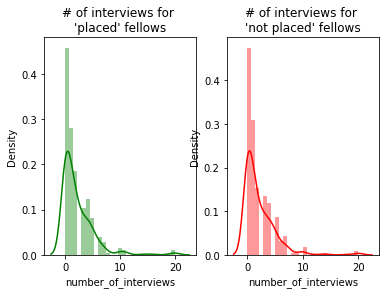

In [902]:
plt.subplot(121)
sns.distplot(pathrise_placed['number_of_interviews'], color='green');
plt.title('# of interviews for \n\'placed\' fellows')
plt.subplot(122)
sns.distplot(pathrise_notplaced['number_of_interviews'], color='red');
plt.title('# of interviews for \n\'not placed\' fellows')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


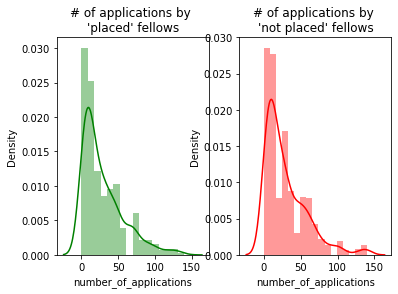

In [903]:
plt.subplot(121)
sns.distplot(pathrise_placed['number_of_applications'], color='green');
plt.title('# of applications by \n\'placed\' fellows')
plt.subplot(122)
sns.distplot(pathrise_notplaced['number_of_applications'], color='red');
plt.title('# of applications by \n\'not placed\' fellows')
plt.show()

# Nothing distinguishes fellows from visual analysis based on the number of applications/interviews.

# Using One-Hot-Encoding in training set + Testing set


In [904]:

from sklearn.preprocessing import OneHotEncoder

oe_style = OneHotEncoder()

# 'work_authorization_status'
oe_results_work_author = oe_style.fit_transform(pathrise_first[['work_authorization_status']])
work_author=pd.DataFrame(oe_results_work_author.toarray(), columns=oe_style.categories_)
work_author.head()

,Canada Citizen,Citizen,F1 Visa/CPT,F1 Visa/OPT,Green Card,H1B,Not Authorized,Other,STEM OPT
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [905]:
# 'biggest_challenge_in_search'

oe_results_big_challenge = oe_style.fit_transform(pathrise_first[['biggest_challenge_in_search']])
big_challenge=pd.DataFrame(oe_results_big_challenge.toarray(), columns=oe_style.categories_)
big_challenge.head()

,Behavioral interviewing,Figuring out which jobs to apply for,Getting past final round interviews,Getting past mid-stage interviews,Getting past phone screens,Hearing back on my applications,Lack of relevant experience,Resume gap,Technical interviewing,Technical skills
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [906]:
# 'employment_status'
oe_results_employ_stat = oe_style.fit_transform(pathrise_first[['employment_status']])
employ_stat=pd.DataFrame(oe_results_employ_stat.toarray(), columns=oe_style.categories_)
employ_stat.head()

,Contractor,Employed Full-Time,Employed Part-Time,Student,Unemployed
0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0


In [907]:
# 'primary_track'
oe_results_primary_track = oe_style.fit_transform(pathrise_first[['primary_track']])
primary_track=pd.DataFrame(oe_results_primary_track.toarray(), columns=oe_style.categories_)
primary_track.head()

,Data,Design,PSO,SWE,Web
0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0


In [908]:
# 'highest_level_of_education'
oe_results_education = oe_style.fit_transform(pathrise_first[['highest_level_of_education']])
education=pd.DataFrame(oe_results_education.toarray(), columns=oe_style.categories_)
education.head()

,Bachelor's Degree,Doctorate or Professional Degree,GED or equivalent,High School Graduate,Master's Degree,"Some College, No Degree",Some High School
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [909]:
# 'highest_level_of_education'
oe_results_education = oe_style.fit_transform(pathrise_first[['race']])
race=pd.DataFrame(oe_results_education.toarray(), columns=oe_style.categories_)
race.head()

,"Black, Afro-Caribbean, or African American",Decline to Self Identify,East Asian or Asian American,Latino or Hispanic American,Middle Eastern or Arab American,Non-Hispanic White or Euro-American,South Asian or Indian American,Two or More Races
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [910]:
# 'gender'
oe_results_gender = oe_style.fit_transform(pathrise_first[['gender']])
gender=pd.DataFrame(oe_results_gender.toarray(), columns=oe_style.categories_)
gender=gender.drop(columns=['Decline to Self Identify'])
gender.head()

,Female,Male,Non-Binary
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0


# Joining all the encoded dataset to the master dataset to create 'pathrise_ready'. Then we split the dataset to train and test based on 'pathrise_status'.


In [911]:
pathrise_ready=pathrise_first.reset_index(drop=True, inplace=False)
pathrise_ready=pathrise_ready.join(education).join(big_challenge).join(employ_stat).join(primary_track).join(work_author) #.join(race).join(gender)
pathrise_ready=pathrise_ready.drop(columns=['highest_level_of_education', 'primary_track', 'employment_status', 'biggest_challenge_in_search', 'work_authorization_status', 'race', 'gender', 'number_of_applications'])

pathrise_ready

,pathrise_status,placed,number_of_interviews,professional_experience_ord,length_of_job_search_ord,"(Bachelor's Degree,)","(Doctorate or Professional Degree,)","(GED or equivalent,)","(High School Graduate,)","(Master's Degree,)","(Some College, No Degree,)","(Some High School,)","(Behavioral interviewing,)","(Figuring out which jobs to apply for,)","(Getting past final round interviews,)","(Getting past mid-stage interviews,)","(Getting past phone screens,)","(Hearing back on my applications,)","(Lack of relevant experience,)","(Resume gap,)","(Technical interviewing,)","(Technical skills,)","(Contractor,)","(Employed Full-Time,)","(Employed Part-Time,)","(Student,)","(Unemployed,)","(Data,)","(Design,)","(PSO,)","(SWE,)","(Web,)","(Canada Citizen,)","(Citizen,)","(F1 Visa/CPT,)","(F1 Visa/OPT,)","(Green Card,)","(H1B,)","(Not Authorized,)","(Other,)","(STEM OPT,)"
0,Active,0,6.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Closed Lost,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Closed Lost,0,5.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Placed,1,10.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,Closed Lost,0,5.0,3.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413,Placed,1,0.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1414,Withdrawn,0,1.0,5.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1415,Withdrawn (Failed),0,4.0,5.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1416,Active,0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [918]:
pathrise_test=pathrise_ready[(pathrise_ready['pathrise_status']=='Active') | (pathrise_ready['pathrise_status']=='Break')].drop(columns='pathrise_status')
pathrise_train=pathrise_ready[(pathrise_ready['pathrise_status']!='Active') & (pathrise_ready['pathrise_status']!='Break')].drop(columns='pathrise_status')

# Training and testing data

In [919]:
X_train=pathrise_train.drop(columns='placed')
y_train=pathrise_train['placed']

X_test=pathrise_test.drop(columns='placed')
y_test=pathrise_test['placed']

# We use 'train_test_split' from Sckit_learn to create a training and validation datasets.

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0)

# Dimensionality reduction using PCA

In [920]:
from sklearn import decomposition
from sklearn.decomposition import PCA

pca = decomposition.PCA() #n_components=5
pca.fit(X_train)
X_train = pca.transform(X_train)
X_val = pca.transform(X_val)
X_test = pca.transform(X_test)

In [921]:
# Feature scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

# Decision Tree model

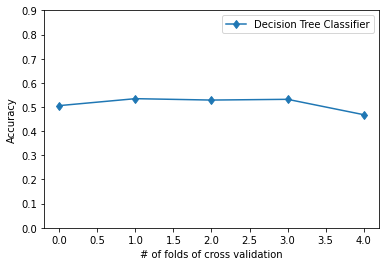

In [922]:
clf = DecisionTreeClassifier()
cv_score = cross_val_score(clf, 
                            X_train, y_train,
                            scoring = 'accuracy',
                            cv = 5,
                            n_jobs = -1,
                            verbose = 0)

plt.plot(cv_score, 'd-',label='Decision Tree Classifier')
plt.xlabel('# of folds of cross validation')
plt.ylabel('Accuracy')
plt.ylim(0,0.9)
plt.legend()

plt.show()

# Logistic regression model

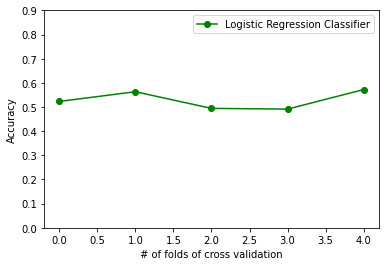

In [923]:
clf=LogisticRegression()
cv_score = cross_val_score(clf, 
                            X_train, y_train,
                            scoring = 'accuracy',
                            cv = 5,
                            n_jobs = -1,
                            verbose = 0)

plt.plot(cv_score, 'go-',label='Logistic Regression Classifier')
plt.xlabel('# of folds of cross validation')
plt.ylabel('Accuracy')
plt.ylim(0,0.9)
plt.legend()
plt.show()

# Random Forest Classifier

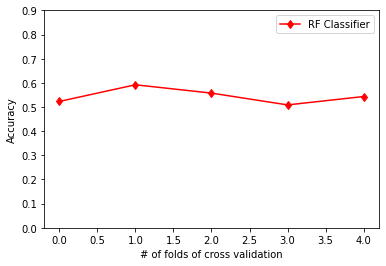

In [924]:
clf = RandomForestClassifier(n_estimators=40, random_state=0)
cv_score = cross_val_score(clf, 
                            X_train, y_train,
                            scoring = 'accuracy',
                            cv = 5,
                            n_jobs = -1,
                            verbose = 0)

plt.plot(cv_score, 'rd-',label='RF Classifier')
plt.xlabel('# of folds of cross validation')
plt.ylabel('Accuracy')
plt.ylim(0,0.9)
plt.legend()
plt.show()

# K-NN Classifier

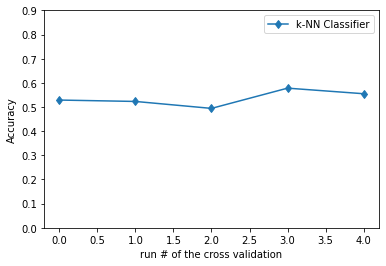

In [925]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=6)
cv_score = cross_val_score(clf, 
                            X_train, y_train,
                            scoring = 'accuracy',
                            cv = 5,
                            n_jobs = -1,
                            verbose = 0)

plt.plot(cv_score, 'd-',label='k-NN Classifier')
plt.xlabel('run # of the cross validation')
plt.ylabel('Accuracy')
plt.ylim(0,0.9)
plt.legend()
plt.show()

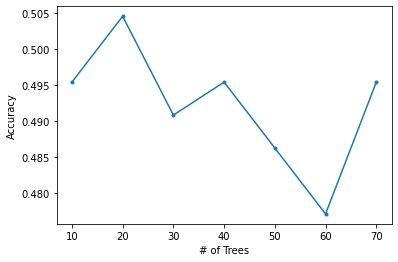

In [926]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

accu=[]
for i in np.arange(10, 80, 10):
  classifier = RandomForestClassifier(n_estimators=i, random_state=0)
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_val)

  # print(confusion_matrix(y_val,y_pred))
  # print(classification_report(y_val,y_pred))
  # print(accuracy_score(y_val, y_pred))
  accu.append(accuracy_score(y_val, y_pred))

plt.plot(np.arange(10, 80, 10), accu, '.-')
plt.xlabel('# of Trees')
plt.ylabel('Accuracy')
plt.show()
# plt.savefig('rf_training.png')

[[73 40]
 [68 37]]
              precision    recall  f1-score   support

           0       0.52      0.65      0.57       113
           1       0.48      0.35      0.41       105

    accuracy                           0.50       218
   macro avg       0.50      0.50      0.49       218
weighted avg       0.50      0.50      0.49       218

0.5045871559633027


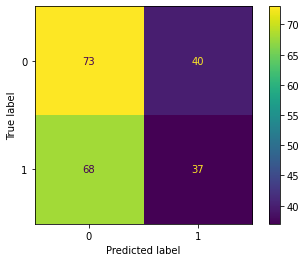

In [927]:
from sklearn.metrics import plot_confusion_matrix

classifier = RandomForestClassifier(n_estimators=20, random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_val)

print(confusion_matrix(y_val,y_pred))
print(classification_report(y_val,y_pred))
print(accuracy_score(y_val, y_pred))
plot_confusion_matrix(classifier, X_val, y_val)  
plt.show()

# Task - 2

## Determine how fast do fellows get placed

In [928]:
# Removing the outliers in 'number_of_applications': 400 and 1000 applications are way above 95%.

pathrise_2=pathrise.drop(columns=['id', 'cohort_tag', 'professional_experience', 'length_of_job_search']) 
print('Before removing missing values, shape:', pathrise_2.shape)

pathrise_2.dropna(inplace=True)
print('After removing missing values, shape:', pathrise_2.shape)

Before removing missing values, shape: (2438, 14)
After removing missing values, shape: (1062, 14)


In [929]:
pathrise_2_train=pathrise_2[(pathrise_2['pathrise_status']=='Placed') & (pathrise_2['placed']==1)].drop(columns=['pathrise_status', 'placed'])
pathrise_2_train.head()

,primary_track,program_duration_days,employment_status,highest_level_of_education,biggest_challenge_in_search,work_authorization_status,number_of_interviews,number_of_applications,gender,race,professional_experience_ord,length_of_job_search_ord
4,SWE,89.0,Unemployed,Bachelor's Degree,Hearing back on my applications,F1 Visa/OPT,10.0,100,Male,East Asian or Asian American,2.0,2.0
23,PSO,193.0,Unemployed,Master's Degree,Hearing back on my applications,Citizen,5.0,4,Male,Non-Hispanic White or Euro-American,2.0,4.0
30,SWE,73.0,Student,Master's Degree,Figuring out which jobs to apply for,F1 Visa/CPT,0.0,1,Male,East Asian or Asian American,2.0,1.0
54,SWE,76.0,Student,Master's Degree,Getting past final round interviews,F1 Visa/OPT,0.0,30,Female,East Asian or Asian American,3.0,1.0
63,SWE,65.0,Unemployed,Bachelor's Degree,Getting past phone screens,F1 Visa/OPT,0.0,0,Female,"Black, Afro-Caribbean, or African American",2.0,2.0


count    525.000000
mean     162.889524
std      103.029248
min        1.000000
25%       78.000000
50%      144.000000
75%      239.000000
max      548.000000
Name: program_duration_days, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


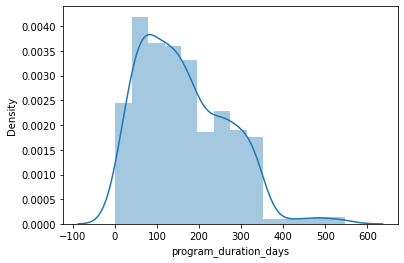

In [930]:
# See the statistics of the target variable 

print(pathrise_2_train['program_duration_days'].describe())
sns.distplot(pathrise_2_train['program_duration_days'])
plt.show()

In [931]:
# Check skewness and the curtosis

print("Skewness: %f" % pathrise_2_train['program_duration_days'].skew())
print("Kurtosis: %f" % pathrise_2_train['program_duration_days'].kurt())

Skewness: 0.714148
Kurtosis: 0.239682


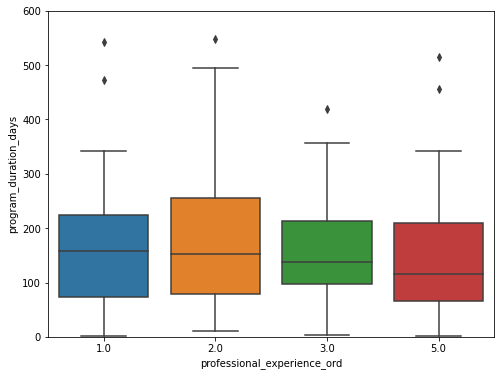

In [932]:
# The most experienced gets placed faster.

var = 'professional_experience_ord'
data = pd.concat([pathrise_2_train['program_duration_days'], pathrise_2_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y='program_duration_days', data=data)
fig.axis(ymin=0, ymax=600);

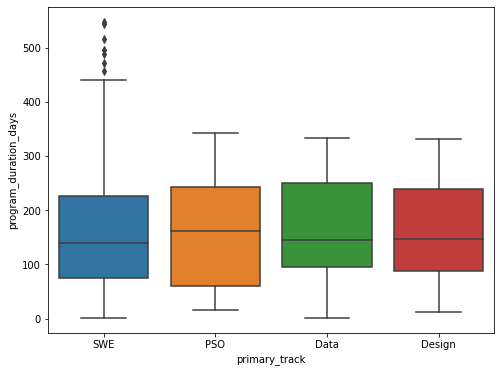

In [933]:
# SWE has the lowest mean. Higher variance for PSO.

var = 'primary_track'
data = pd.concat([pathrise_2_train['program_duration_days'], pathrise_2_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y='program_duration_days', data=data)


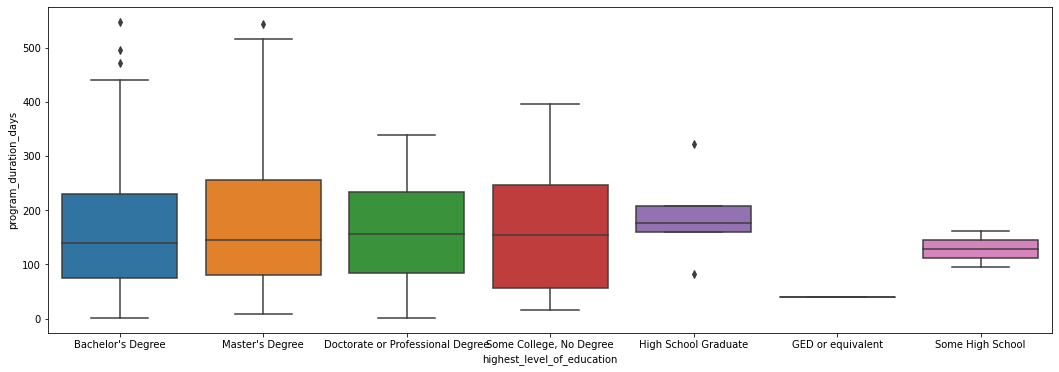

In [934]:
# SWE has the lowest mean. Higher variance for PSO.

var = 'highest_level_of_education'
data = pd.concat([pathrise_2_train['program_duration_days'], pathrise_2_train[var]], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x=var, y='program_duration_days', data=data)


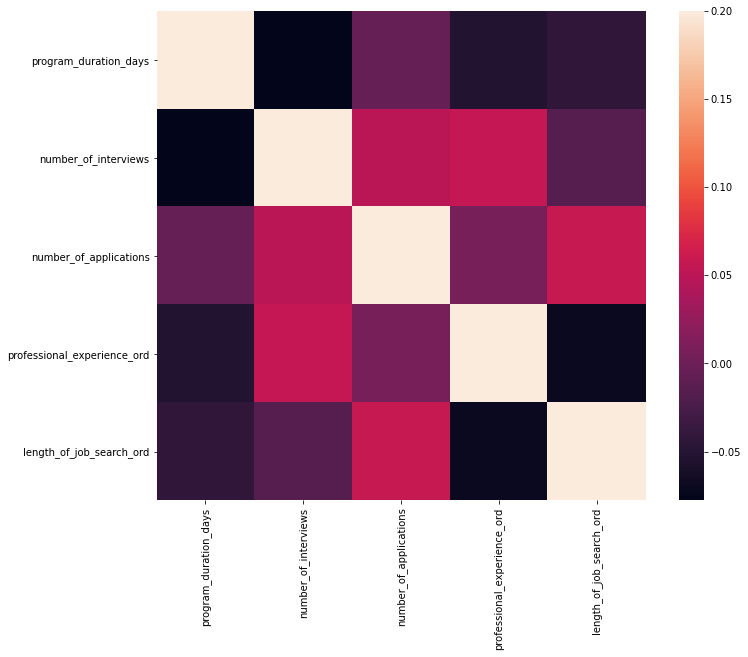

In [935]:
#correlation matrix

corrmat = pathrise_2_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=0.2, square=True);

In [936]:
pathrise_2_train.columns

Index(['primary_track', 'program_duration_days', 'employment_status',
       'highest_level_of_education', 'biggest_challenge_in_search',
       'work_authorization_status', 'number_of_interviews',
       'number_of_applications', 'gender', 'race',
       'professional_experience_ord', 'length_of_job_search_ord'],
      dtype='object')

# Using One-Hot-Encoding in training set + Testing set


In [937]:
from sklearn.preprocessing import OneHotEncoder

oe_style = OneHotEncoder()

# 'work_authorization_status'
oe_results_work_author = oe_style.fit_transform(pathrise_2[['work_authorization_status']])
work_author=pd.DataFrame(oe_results_work_author.toarray(), columns=oe_style.categories_)
work_author.head()

,Canada Citizen,Citizen,F1 Visa/CPT,F1 Visa/OPT,Green Card,H1B,Not Authorized,Other,STEM OPT
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [938]:
# 'biggest_challenge_in_search'

oe_results_big_challenge = oe_style.fit_transform(pathrise_2[['biggest_challenge_in_search']])
big_challenge=pd.DataFrame(oe_results_big_challenge.toarray(), columns=oe_style.categories_)
big_challenge.head()

,Behavioral interviewing,Figuring out which jobs to apply for,Getting past final round interviews,Getting past mid-stage interviews,Getting past phone screens,Hearing back on my applications,Lack of relevant experience,Resume gap,Technical interviewing,Technical skills
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [939]:
# 'employment_status'
oe_results_employ_stat = oe_style.fit_transform(pathrise_2[['employment_status']])
employ_stat=pd.DataFrame(oe_results_employ_stat.toarray(), columns=oe_style.categories_)
employ_stat.head()

,Contractor,Employed Full-Time,Employed Part-Time,Student,Unemployed
0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0


In [940]:
# 'primary_track'
oe_results_primary_track = oe_style.fit_transform(pathrise_2[['primary_track']])
primary_track=pd.DataFrame(oe_results_primary_track.toarray(), columns=oe_style.categories_)
primary_track.head()

,Data,Design,PSO,SWE,Web
0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0


In [941]:
# 'highest_level_of_education'
oe_results_education = oe_style.fit_transform(pathrise_2[['highest_level_of_education']])
education=pd.DataFrame(oe_results_education.toarray(), columns=oe_style.categories_)
education.head()

,Bachelor's Degree,Doctorate or Professional Degree,GED or equivalent,High School Graduate,Master's Degree,"Some College, No Degree",Some High School
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [942]:
# 'race'
oe_results_education = oe_style.fit_transform(pathrise_2[['race']])
race=pd.DataFrame(oe_results_education.toarray(), columns=oe_style.categories_)
race.head()

,"Black, Afro-Caribbean, or African American",Decline to Self Identify,East Asian or Asian American,Latino or Hispanic American,Middle Eastern or Arab American,Non-Hispanic White or Euro-American,South Asian or Indian American,Two or More Races
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [943]:
# 'gender'
oe_results_gender = oe_style.fit_transform(pathrise_2[['gender']])
gender=pd.DataFrame(oe_results_gender.toarray(), columns=oe_style.categories_)
gender=gender.drop(columns=['Decline to Self Identify'])
gender.head()

,Female,Male,Non-Binary
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0


In [944]:
pathrise_2_ready=pathrise_2.reset_index(drop=True, inplace=False)
pathrise_2_ready=pathrise_2_ready.join(education).join(big_challenge).join(employ_stat).join(primary_track).join(work_author) #.join(race).join(gender)
pathrise_2_ready=pathrise_2_ready.drop(columns=['highest_level_of_education', 'primary_track', 'employment_status', 'biggest_challenge_in_search', 'work_authorization_status', 'race', 'gender']) #, 'number_of_applications'

pathrise_2_ready

,pathrise_status,program_duration_days,placed,number_of_interviews,number_of_applications,professional_experience_ord,length_of_job_search_ord,"(Bachelor's Degree,)","(Doctorate or Professional Degree,)","(GED or equivalent,)","(High School Graduate,)","(Master's Degree,)","(Some College, No Degree,)","(Some High School,)","(Behavioral interviewing,)","(Figuring out which jobs to apply for,)","(Getting past final round interviews,)","(Getting past mid-stage interviews,)","(Getting past phone screens,)","(Hearing back on my applications,)","(Lack of relevant experience,)","(Resume gap,)","(Technical interviewing,)","(Technical skills,)","(Contractor,)","(Employed Full-Time,)","(Employed Part-Time,)","(Student,)","(Unemployed,)","(Data,)","(Design,)","(PSO,)","(SWE,)","(Web,)","(Canada Citizen,)","(Citizen,)","(F1 Visa/CPT,)","(F1 Visa/OPT,)","(Green Card,)","(H1B,)","(Not Authorized,)","(Other,)","(STEM OPT,)"
0,Closed Lost,0.0,0,0.0,0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Closed Lost,0.0,0,5.0,25,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Placed,89.0,1,10.0,100,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,Closed Lost,0.0,0,5.0,100,3.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,Closed Lost,0.0,0,0.0,9,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057,Withdrawn (Trial),9.0,0,4.0,15,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1058,Placed,119.0,1,0.0,10,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1059,Withdrawn,118.0,0,1.0,25,5.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1060,Withdrawn (Failed),457.0,0,4.0,15,5.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [945]:
# Training set is all the fellows who got placed. The we will split it into a validation set for testing.
pathrise_2_train=pathrise_2_ready[(pathrise_2_ready['pathrise_status']=='Placed') & (pathrise_2_ready['placed']==1)].drop(columns=['pathrise_status', 'placed'])


# Training and testing data for Task - 2

In [946]:
X_train2=pathrise_2_train.drop(columns='program_duration_days')
y_train2=pathrise_2_train['program_duration_days']

# We use 'train_test_split' from Sckit_learn to create a training and validation datasets.

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train2, y_train2, test_size = 0.2, random_state = 0)

# Dimensionality reduction using PCA

In [947]:
from sklearn import decomposition
from sklearn.decomposition import PCA

pca = decomposition.PCA()
pca.fit(X_train2)
X_train2 = pca.transform(X_train2)
X_test2 = pca.transform(X_test2)

In [948]:
# Feature scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train2 = sc.fit_transform(X_train2)

X_test2 = sc.transform(X_test2)

# Linear regression model

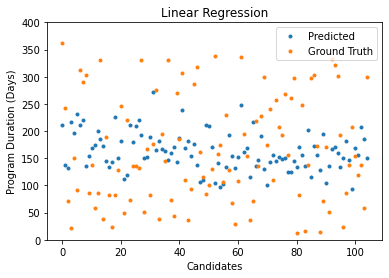

0.10680280949543008


In [953]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train2, y_train2)
y_pred2 = reg.predict(X_test2)

plt.plot(np.array(y_pred2),'.', label='Predicted')
plt.plot(np.array(y_test2),'.', label='Ground Truth')
plt.xlabel('Candidates')
plt.ylabel('Program Duration (Days)')
plt.title('Linear Regression')
plt.legend()
plt.ylim(0,400)
plt.show()

print(reg.score(X_train2, y_train2))

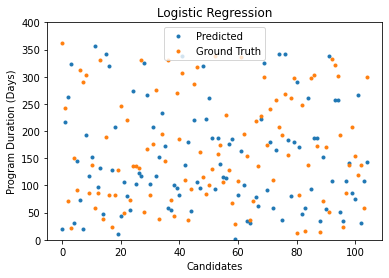

0.8357142857142857


In [955]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, max_iter=500).fit(X_train2, y_train2)
y_pred2 = clf.predict(X_test2)

plt.plot(np.array(y_pred2),'.', label='Predicted')
plt.plot(np.array(y_test2),'.', label='Ground Truth')
plt.xlabel('Candidates')
plt.ylabel('Program Duration (Days)')
plt.title('Logistic Regression')
plt.legend()
plt.ylim(0,400)
plt.show()

print(clf.score(X_train2, y_train2))

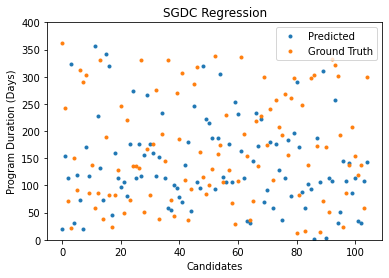

0.7333333333333333


In [956]:
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Always scale the input. The most convenient way is to use a pipeline.
clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))
clf.fit(X_train2, y_train2)

y_pred2=clf.predict((X_test2))

plt.plot(np.array(y_pred2),'.', label='Predicted')
plt.plot(np.array(y_test2),'.', label='Ground Truth')
plt.xlabel('Candidates')
plt.ylabel('Program Duration (Days)')
plt.title('SGDC Regression')
plt.legend()
plt.ylim(0,400)
plt.show()

print(clf.score(X_train2, y_train2))